In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import re
import warnings
from scipy.stats import uniform
warnings.filterwarnings('ignore')

In [21]:
# Load the datasets
train_data = pd.read_csv('C:../Twitter Sentiment Analysis/twitter_training.csv', header=None)
validation_data = pd.read_csv('C:../Twitter Sentiment Analysis/twitter_validation.csv', header=None)

# Rename columns
train_data.columns = ['id', 'topic', 'sentiment', 'text']
validation_data.columns = ['id', 'topic', 'sentiment', 'text']

# Display the first few rows of the datasets
print(train_data.head())
print(validation_data.head())

     id        topic sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
     id      topic   sentiment  \
0  3364   Facebook  Irrelevant   
1   352     Amazon     Neutral   
2  8312  Microsoft    Negative   
3  4371      CS-GO    Negative   
4  4433     Google     Neutral   

                                                text  
0  I mentioned on Facebook that I was struggling ...  
1  BBC News - Amazon boss Jeff Bezos rejects clai...  
2  @Microsoft Why do I pay for WORD when it funct...  
3  CSGO matchmaking is so full of closet

In [22]:
# Check for missing values and data types
print(train_data.info())
print(train_data.describe())
print(validation_data.info())
print(validation_data.describe())

# Distribution of the target variable
print(train_data['sentiment'].value_counts())
print(validation_data['sentiment'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74682 non-null  int64 
 1   topic      74682 non-null  object
 2   sentiment  74682 non-null  object
 3   text       73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB
None
                 id
count  74682.000000
mean    6432.586165
std     3740.427870
min        1.000000
25%     3195.000000
50%     6422.000000
75%     9601.000000
max    13200.000000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1000 non-null   int64 
 1   topic      1000 non-null   object
 2   sentiment  1000 non-null   object
 3   text       1000 non-null   object
dtypes: int64(1), object(3)
memory usage: 31.4+ KB
None
                 id
count   

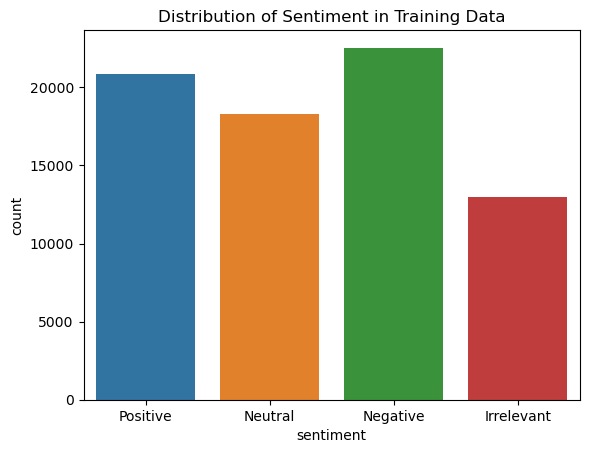

In [23]:
# Visualizing the distribution of the target variable in the training set
sns.countplot(x='sentiment', data=train_data)
plt.title('Distribution of Sentiment in Training Data')
plt.show()

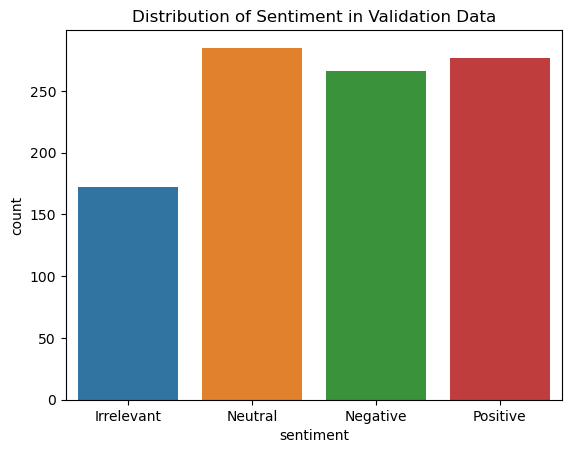

In [24]:
# Visualizing the distribution of the target variable in the validation set
sns.countplot(x='sentiment', data=validation_data)
plt.title('Distribution of Sentiment in Validation Data')
plt.show()

In [25]:
# Remove any rows with NaN values in the 'text' or 'sentiment' columns
train_data.dropna(subset=['text', 'sentiment'], inplace=True)
validation_data.dropna(subset=['text', 'sentiment'], inplace=True)

# Check for null values again
print(train_data.isnull().sum())
print(validation_data.isnull().sum())

id           0
topic        0
sentiment    0
text         0
dtype: int64
id           0
topic        0
sentiment    0
text         0
dtype: int64


In [26]:
# Text preprocessing function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [27]:
# Apply text preprocessing
train_data['text'] = train_data['text'].apply(preprocess_text)
validation_data['text'] = validation_data['text'].apply(preprocess_text)

In [29]:
# Splitting the data into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(train_data['text'], train_data['sentiment'], test_size=0.2, random_state=42)

# Display the shapes of the splits
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(59196,) (14800,) (59196,) (14800,)


In [30]:
# Initializing TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,3))

# Function for Model Evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [31]:
# Building a pipeline for the model
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('logreg', LogisticRegression(solver='liblinear'))
])

In [32]:
# Hyperparameter tuning
param_dist = {
    'logreg__C': uniform(0.01, 10),
    'logreg__penalty': ['l2', 'l1']
}
random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=50, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('tfidf',
                                              TfidfVectorizer(max_features=10000,
                                                              ngram_range=(1,
                                                                           3))),
                                             ('logreg',
                                              LogisticRegression(solver='liblinear'))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'logreg__C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001753F888210>,
                                        'logreg__penalty': ['l2', 'l1']},
                   random_state=42, verbose=2)

In [33]:
# Best parameters
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'logreg__C': 9.498855372533333, 'logreg__penalty': 'l1'}


In [34]:
# Best model
best_model = random_search.best_estimator_

Accuracy:  0.7675675675675676
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.76      0.68      0.72      2696
    Negative       0.81      0.82      0.81      4380
     Neutral       0.72      0.74      0.73      3605
    Positive       0.76      0.79      0.78      4119

    accuracy                           0.77     14800
   macro avg       0.77      0.76      0.76     14800
weighted avg       0.77      0.77      0.77     14800



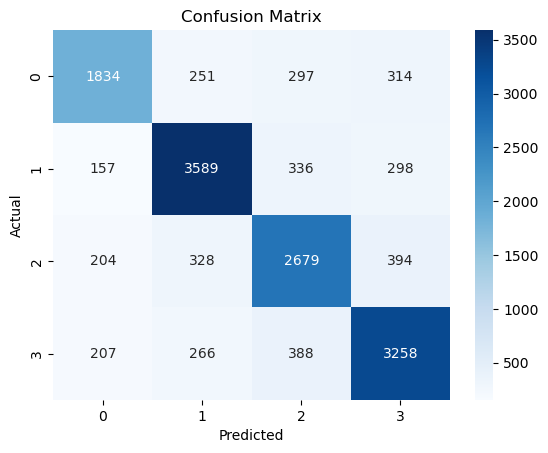

Accuracy:  0.913
Classification Report:
               precision    recall  f1-score   support

  Irrelevant       0.92      0.90      0.91       172
    Negative       0.91      0.93      0.92       266
     Neutral       0.93      0.89      0.91       285
    Positive       0.89      0.92      0.91       277

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



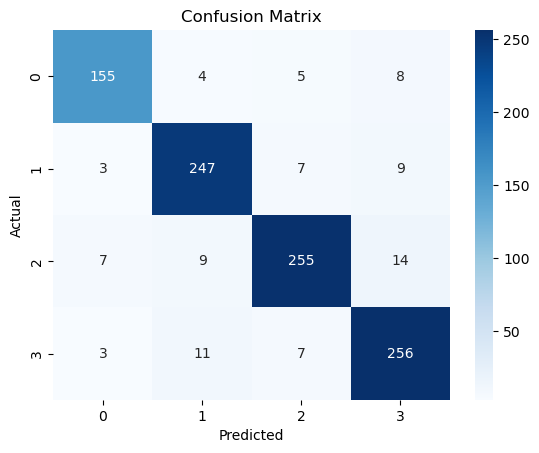

In [35]:
# Model Evaluation on test set
evaluate_model(best_model, X_test, y_test)

# Model Evaluation on validation set
evaluate_model(best_model, validation_data['text'], validation_data['sentiment'])